# Data Pipeline

ah shit, 
here we go again
{insert cj meme here}

In [1]:
from _Setup import *

In [2]:
train_data = pd.read_csv(rawTrainFile)
test_data = pd.read_csv(rawTestFile)

C:\Users\Marin\AppData\Local\Temp\ipykernel_17280\3702163432.py:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  test_data = pd.read_csv(rawTestFile)


# Train data preparation

In [3]:
# backward fill function
def backward_fill_by_patient(df, patient_id_col='patient'):
    # Create a copy of the original DataFrame
    df_imputed = df.copy()

    df_imputed.loc[:, df_imputed.columns != patient_id_col] = (
        df_imputed.groupby(patient_id_col)
        .bfill()
    )

    # If there are patients with no entries for a column, those columns will remain unchanged
    return df_imputed

In [4]:
def forward_fill_by_patient(df, patient_id_col='patient'):
    # Create a copy of the original DataFrame
    df_imputed = df.copy()

    df_imputed.loc[:, df_imputed.columns != patient_id_col] = (
        df_imputed.groupby(patient_id_col)
        .ffill()
    )
    
    # If there are patients with no entries for a column, those columns will remain unchanged
    return df_imputed

## Remove Columns w/ > 95% initial missing values and B/F imputation

In [5]:
# Identify columns with more than 90% missing values

missing_percentage = train_data.isnull().mean() * 100

cols_to_drop_for_missing_percentage = missing_percentage[missing_percentage > 95].index

# Drop the identified columns

train_truncated = train_data.drop(columns=cols_to_drop_for_missing_percentage)

In [6]:
#forward imputation
train_forward = forward_fill_by_patient(train_truncated)
train_forward.head()

,patient,time,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,BaseExcess,...,Hgb,WBC,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel
0,16426,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,57.03,1.0,0.0,1.0,-4.25,1.0,0.0
1,16426,2,78.0,99.5,35.25,108.5,84.5,69.0,12.0,0.0,...,12.0,14.2,NaN,57.03,1.0,0.0,1.0,-4.25,2.0,0.0
2,16426,3,80.0,99.0,36.20,113.0,87.0,73.0,12.0,0.0,...,12.0,14.2,NaN,57.03,1.0,0.0,1.0,-4.25,3.0,0.0
3,16426,4,79.0,100.0,36.50,112.0,83.0,68.0,12.0,-2.5,...,12.0,14.2,NaN,57.03,1.0,0.0,1.0,-4.25,4.0,0.0
4,16426,5,73.0,100.0,36.50,115.0,80.0,64.0,11.0,-2.5,...,12.0,14.2,NaN,57.03,1.0,0.0,1.0,-4.25,5.0,0.0


In [7]:
#backward imputation
pre_imputed_train = backward_fill_by_patient(train_forward)
pre_imputed_train.head()  

,patient,time,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,BaseExcess,...,Hgb,WBC,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel
0,16426,1,78.0,99.5,35.25,108.5,84.5,69.0,12.0,0.0,...,12.0,14.2,162.0,57.03,1.0,0.0,1.0,-4.25,1.0,0.0
1,16426,2,78.0,99.5,35.25,108.5,84.5,69.0,12.0,0.0,...,12.0,14.2,162.0,57.03,1.0,0.0,1.0,-4.25,2.0,0.0
2,16426,3,80.0,99.0,36.20,113.0,87.0,73.0,12.0,0.0,...,12.0,14.2,162.0,57.03,1.0,0.0,1.0,-4.25,3.0,0.0
3,16426,4,79.0,100.0,36.50,112.0,83.0,68.0,12.0,-2.5,...,12.0,14.2,162.0,57.03,1.0,0.0,1.0,-4.25,4.0,0.0
4,16426,5,73.0,100.0,36.50,115.0,80.0,64.0,11.0,-2.5,...,12.0,14.2,162.0,57.03,1.0,0.0,1.0,-4.25,5.0,0.0


In [8]:
# Identify columns with more than 90% missing values

missing_percentage = pre_imputed_train.isnull().mean() * 100

cols_to_drop_for_missing_percentage2 = missing_percentage[missing_percentage > 80].index

print(cols_to_drop_for_missing_percentage2)

Index([], dtype='object')


## MissForest imputation

In [9]:
naPercentages = pd.DataFrame(pre_imputed_train.isna().sum() / pre_imputed_train.shape[0], columns=['Percentage'])
naPercentages.sort_values(by = ['Percentage'], ascending=False).head(10)
                             

,Percentage
BaseExcess,0.637390
FiO2,0.501017
PaCO2,0.485635
pH,0.471871
Unit1,0.391502
Unit2,0.391502
DBP,0.166844
Calcium,0.096244
Magnesium,0.087443
WBC,0.041200


In [10]:
np.random.seed(8)
samplePatients = np.random.choice(pre_imputed_train['patient'].unique(), size = (10000), replace = False)

sample_pool = pre_imputed_train[pre_imputed_train['patient'].isin(samplePatients)]

sample_pool = sample_pool.drop('SepsisLabel', axis = 1)
sample_pool.shape

(386586, 29)

In [11]:
imputed_sample = pd.DataFrame(sample_pool, columns=sample_pool.columns)

imputer = MissForest()
imputer.fit(imputed_sample)

# NOTE :
This needs python 3.12 to get the .fit and .transforms funcitons on the MissForest imputer

In [12]:
imputer_input = pre_imputed_train.drop('SepsisLabel', axis = 1)
imputed_data = imputer.transform(imputer_input)

imputed_data['SepsisLabel'] = pre_imputed_train['SepsisLabel']

imputed_data.isna().sum()

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [16:56<00:00, 203.25s/it]


patient        0
time           0
HR             0
O2Sat          0
Temp           0
SBP            0
MAP            0
DBP            0
Resp           0
BaseExcess     0
FiO2           0
pH             0
PaCO2          0
BUN            0
Calcium        0
Creatinine     0
Glucose        0
Magnesium      0
Potassium      0
Hct            0
Hgb            0
WBC            0
Platelets      0
Age            0
Gender         0
Unit1          0
Unit2          0
HospAdmTime    0
ICULOS         0
SepsisLabel    0
dtype: int64

# SMOTE

In [ ]:
# TODO : Look into this

X = imputed_data.drop(columns = ['SepsisLabel'])
y = imputed_data['SepsisLabel']


sm = SMOTE(sampling_strategy=0.3, k_neighbors=5, random_state=8)
X_train_syn, y_train_syn = sm.fit_resample(X, y)

print(imputed_data.iloc[:, 0:4].describe())
print(X_train_syn.iloc[:, 0:4].describe())

            patient          time            HR         O2Sat
count  1.088197e+06  1.088197e+06  1.088197e+06  1.088197e+06
mean   1.410742e+04  2.668297e+01  8.438115e+01  9.715170e+01
std    8.151722e+03  2.955474e+01  1.742592e+01  3.140354e+00
min    1.000000e+00  1.000000e+00  2.000000e+01  2.000000e+01
25%    7.043000e+03  1.000000e+01  7.200000e+01  9.600000e+01
50%    1.410100e+04  2.000000e+01  8.300000e+01  9.800000e+01
75%    2.118100e+04  3.400000e+01  9.500000e+01  9.900000e+01
max    2.823500e+04  4.250000e+02  2.110000e+02  1.001495e+02
            patient          time            HR         O2Sat
count  1.389147e+06  1.389147e+06  1.389147e+06  1.389147e+06
mean   1.412845e+04  3.291582e+01  8.575201e+01  9.711659e+01
std    8.159747e+03  4.027605e+01  1.793534e+01  3.179952e+00
min    1.000000e+00  1.000000e+00  2.000000e+01  2.000000e+01
25%    7.043000e+03  1.000000e+01  7.300000e+01  9.600000e+01
50%    1.416300e+04  2.200000e+01  8.450000e+01  9.800000e+01
75%    2

In [117]:
resampled_train = pd.concat([X_train_syn, y_train_syn], axis = 1)
resampled_train.head()

,patient,time,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,BaseExcess,...,Hgb,WBC,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel
0,16426,1,78.0,99.5,35.25,108.5,84.5,69.0,12.0,0.0,...,12.0,14.2,162.0,57.03,1.0,0.0,1.0,-4.25,1.0,0.0
1,16426,2,78.0,99.5,35.25,108.5,84.5,69.0,12.0,0.0,...,12.0,14.2,162.0,57.03,1.0,0.0,1.0,-4.25,2.0,0.0
2,16426,3,80.0,99.0,36.20,113.0,87.0,73.0,12.0,0.0,...,12.0,14.2,162.0,57.03,1.0,0.0,1.0,-4.25,3.0,0.0
3,16426,4,79.0,100.0,36.50,112.0,83.0,68.0,12.0,-2.5,...,12.0,14.2,162.0,57.03,1.0,0.0,1.0,-4.25,4.0,0.0
4,16426,5,73.0,100.0,36.50,115.0,80.0,64.0,11.0,-2.5,...,12.0,14.2,162.0,57.03,1.0,0.0,1.0,-4.25,5.0,0.0


In [118]:
# Before smote distribution 
sepsis_inf = train_data['SepsisLabel'].value_counts()
sepsis_percentages = (sepsis_inf / sepsis_inf.sum()) * 100
print(sepsis_percentages)

SepsisLabel
0.0    98.196924
1.0     1.803076
Name: count, dtype: float64


In [120]:
# After smote distribution
sepsis_inf2 = resampled_train['SepsisLabel'].value_counts()
sepsis_percentages2 = (sepsis_inf2 / sepsis_inf2.sum()) * 100
print(sepsis_percentages2)

SepsisLabel
0.0    76.923105
1.0    23.076895
Name: count, dtype: float64


# Feature Engineering

In [121]:
def FeatureEngineering(df):
    df['Shock'] = df['HR'] / (df['SBP'] + 0.0000001)
    
    # Check if Fever is higher than 38 or lower than 36 at that point or after
    df['Fever'] = df.groupby('patient')['Temp'].transform(
        lambda x: (x < 36).cumsum() + (x > 38).cumsum() > 0
        ).astype(int)
    
    # Check for Tachycardis (HR > 90 BPM)
    df['TCA'] = df.groupby('patient')['HR'].transform(
        lambda x: (x > 90).cumsum() > 0
        ).astype(int)
    
    # Check for Tachypnea (Resp > 20 breaths per minute)
    df['TCP'] = df.groupby('patient')['Resp'].transform(
        lambda x: (x > 20).cumsum() > 0
        ).astype(int)
    
    # Check for Leukocytosis (WBC > 12000) or Leukopenimia (WBC < 4000)
    df['LEU'] = df.groupby('patient')['WBC'].transform(
        lambda x: (x < 4).cumsum() + (x > 12).cumsum() > 0
        ).astype(int)
    
    return df

In [122]:
featured_train = FeatureEngineering(resampled_train)

In [123]:
featured_train.SBP.describe()

count    1.389147e+06
mean     1.230024e+02
std      2.334268e+01
min      0.000000e+00
25%      1.060000e+02
50%      1.200266e+02
75%      1.380000e+02
max      3.000000e+02
Name: SBP, dtype: float64

## Scaling 

In [124]:
# NOTE : This code is not cleaned for SepsisLabel to ensure ease of use at the test step

exclude_scaling_cols = ['patient', 'Gender', 'Unit1', 'Unit2', 'Fever', 'TCP', 'TCA', 'LEU']

# Separate columns into those to scale and those to exclude
cols_to_scale = featured_train.drop(columns=exclude_scaling_cols + ['SepsisLabel']).columns
scaled_data = featured_train[cols_to_scale]

# Scale the selected columns
scaler = StandardScaler()
scaled_scaled_data = pd.DataFrame(scaler.fit_transform(scaled_data), columns=cols_to_scale)

# Combine scaled data with excluded columns and the target variable
scaled_train = pd.concat([scaled_scaled_data, featured_train[exclude_scaling_cols], featured_train['SepsisLabel']], axis=1)

# Display the resulting DataFrame
print(scaled_train.head())

       time        HR     O2Sat      Temp       SBP       MAP       DBP  \
0 -0.792427 -0.432220  0.749512 -2.124421 -0.621283  0.146051  0.420292   
1 -0.767598 -0.432220  0.749512 -2.124421 -0.621283  0.146051  0.420292   
2 -0.742770 -0.320708  0.592277 -0.914129 -0.428503  0.299849  0.716228   
3 -0.717941 -0.376464  0.906747 -0.531932 -0.471343  0.053772  0.346308   
4 -0.693112 -0.710999  0.906747 -0.531932 -0.342823 -0.130785  0.050372   

       Resp  BaseExcess      FiO2  ...     Shock  patient  Gender  Unit1  \
0 -1.294263    0.045536  0.073114  ... -0.000848    16426     1.0    0.0   
1 -1.294263    0.045536  0.073114  ... -0.000848    16426     1.0    0.0   
2 -1.294263    0.045536 -0.000054  ... -0.000848    16426     1.0    0.0   
3 -1.294263   -0.768098 -0.000054  ... -0.000848    16426     1.0    0.0   
4 -1.479445   -0.768098 -0.014687  ... -0.000849    16426     1.0    0.0   

   Unit2  Fever  TCP  TCA  LEU  SepsisLabel  
0    1.0      1    0    0    1          0.0  


## Correlation Matrixes for train data set pipeline

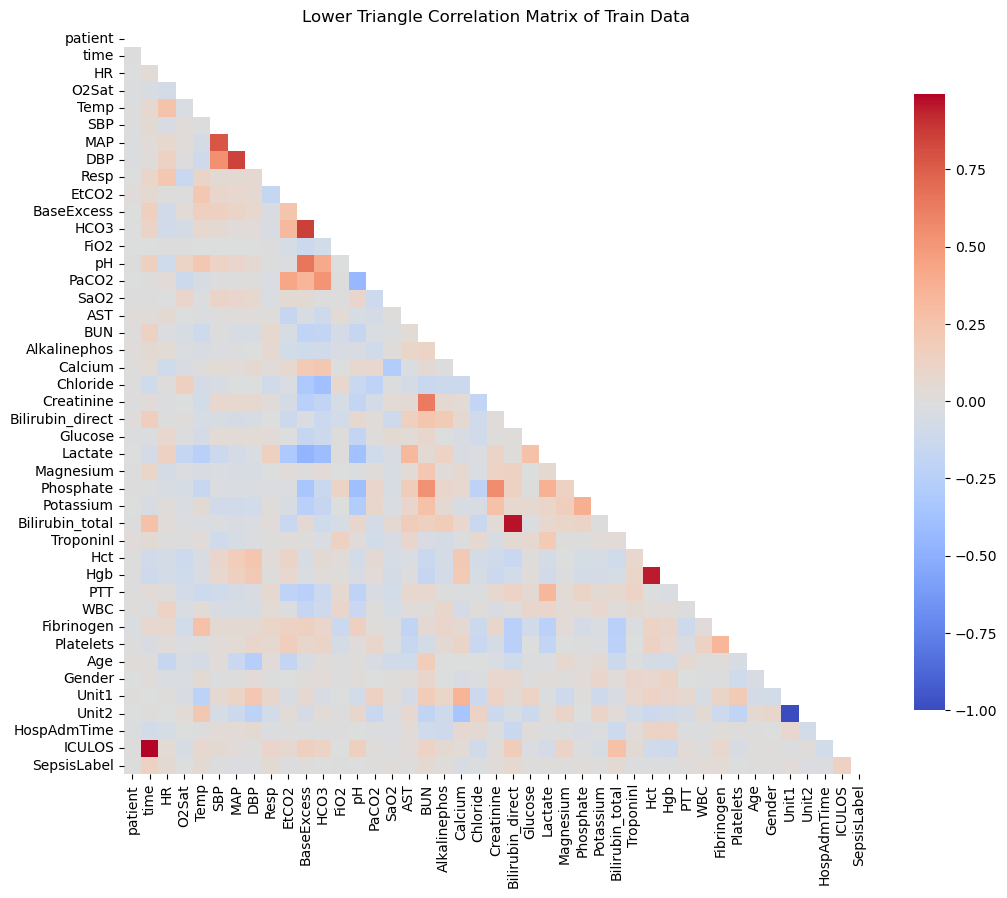

In [125]:
# TODO : Move this to the top of the file

correlation_matrix = train_data.corr()

# Mask the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))


# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Create a heatmap of the correlation matrix, masking the upper triangle
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', square=True, mask=mask, cbar_kws={"shrink": .8})

# Set the title
plt.title('Lower Triangle Correlation Matrix of Train Data')
plt.savefig('Plots/corrmat_train_imputed.png')
plt.show()

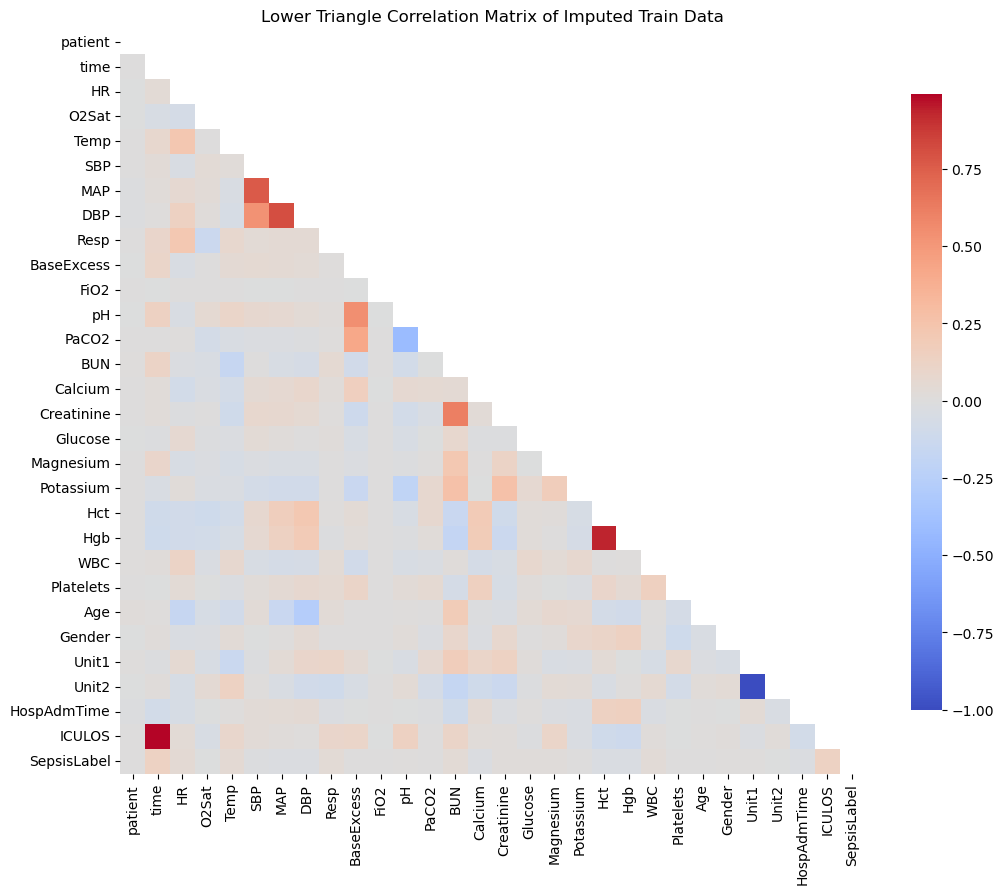

In [126]:
correlation_matrix = imputed_data.corr()

# Mask the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))


# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Create a heatmap of the correlation matrix, masking the upper triangle
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', square=True, mask=mask, cbar_kws={"shrink": .8})

# Set the title
plt.title('Lower Triangle Correlation Matrix of Imputed Train Data')
plt.savefig('Plots/corrmat_train_imputed.png')
plt.show()

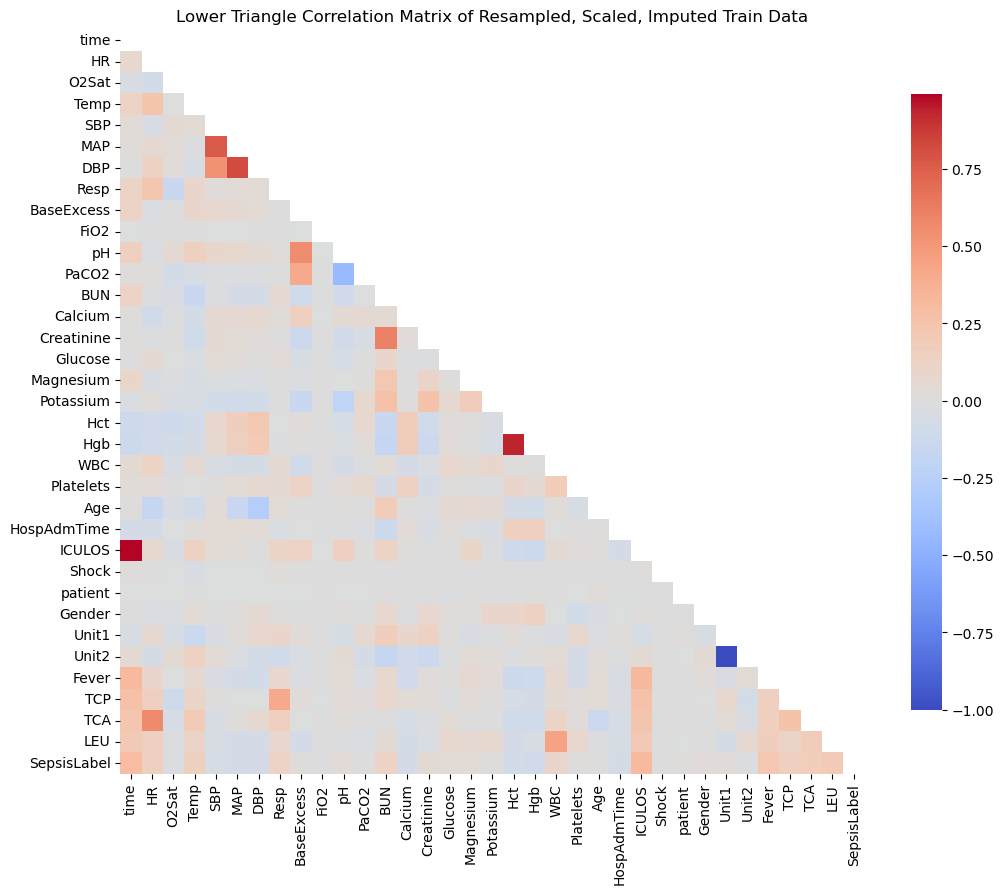

In [127]:
correlation_matrix = scaled_train.corr()

# Mask the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))


# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Create a heatmap of the correlation matrix, masking the upper triangle
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', square=True, mask=mask, cbar_kws={"shrink": .8})

# Set the title
plt.title('Lower Triangle Correlation Matrix of Resampled, Scaled, Imputed Train Data')
plt.savefig('Plots/corrmat_train_imputed.png')
plt.show()

## Distributions for train data set pipeline

In [128]:
def plot_all_variable_distributions(df):
    """
    Plots the distribution of all numerical variables in a DataFrame.
    
    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    """
    
    num_cols = df.select_dtypes(include=['float64', 'int64']).columns
    
    
    num_vars = len(num_cols)
    plt.figure(figsize=(15, 5 * num_vars))
    
    for i, col in enumerate(num_cols):
        plt.subplot(num_vars, 1, i + 1)  
        sns.histplot(df[col], kde=True, bins=30, color='blue')  
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        
    plt.tight_layout()  
    plt.show()


#plot_all_variable_distributions(train_data)

In [129]:
#plot_all_variable_distributions(resampled_train)

## Final train data set to csv

In [130]:
scaled_train.to_csv(missForestTrainFile)

# TEST PIPELINE

## Imputing B/F and missforest

In [131]:
test_dropped = test_data.drop(cols_to_drop_for_missing_percentage, axis = 1)
test_dropped.head()

,patient,time,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,BaseExcess,...,Hct,Hgb,WBC,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS
0,6560,1,110.0,98.0,37.67,124.0,78.00,NaN,16.0,NaN,...,NaN,NaN,NaN,NaN,81.64,1.0,1.0,0.0,-0.03,2.0
1,6560,2,103.0,96.0,NaN,101.0,69.67,NaN,NaN,NaN,...,27.4,NaN,NaN,NaN,81.64,1.0,1.0,0.0,-0.03,3.0
2,6560,3,105.0,96.0,NaN,125.0,75.67,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,81.64,1.0,1.0,0.0,-0.03,4.0
3,6560,4,118.0,94.0,NaN,150.0,94.67,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,81.64,1.0,1.0,0.0,-0.03,5.0
4,6560,5,99.0,94.0,37.50,98.0,64.00,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,81.64,1.0,1.0,0.0,-0.03,6.0


In [132]:
#forward imputation
test_forward = forward_fill_by_patient(test_dropped)
test_forward.head()

,patient,time,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,BaseExcess,...,Hct,Hgb,WBC,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS
0,6560,1,110.0,98.0,37.67,124.0,78.00,NaN,16.0,NaN,...,NaN,NaN,NaN,NaN,81.64,1.0,1.0,0.0,-0.03,2.0
1,6560,2,103.0,96.0,37.67,101.0,69.67,NaN,16.0,NaN,...,27.4,NaN,NaN,NaN,81.64,1.0,1.0,0.0,-0.03,3.0
2,6560,3,105.0,96.0,37.67,125.0,75.67,NaN,16.0,NaN,...,27.4,NaN,NaN,NaN,81.64,1.0,1.0,0.0,-0.03,4.0
3,6560,4,118.0,94.0,37.67,150.0,94.67,NaN,16.0,NaN,...,27.4,NaN,NaN,NaN,81.64,1.0,1.0,0.0,-0.03,5.0
4,6560,5,99.0,94.0,37.50,98.0,64.00,NaN,16.0,NaN,...,27.4,NaN,NaN,NaN,81.64,1.0,1.0,0.0,-0.03,6.0


In [133]:
#forward imputation
pre_imputed_test = backward_fill_by_patient(test_forward)
pre_imputed_test.head()

,patient,time,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,BaseExcess,...,Hct,Hgb,WBC,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS
0,6560,1,110.0,98.0,37.67,124.0,78.00,NaN,16.0,NaN,...,27.4,9.0,7.3,127.0,81.64,1.0,1.0,0.0,-0.03,2.0
1,6560,2,103.0,96.0,37.67,101.0,69.67,NaN,16.0,NaN,...,27.4,9.0,7.3,127.0,81.64,1.0,1.0,0.0,-0.03,3.0
2,6560,3,105.0,96.0,37.67,125.0,75.67,NaN,16.0,NaN,...,27.4,9.0,7.3,127.0,81.64,1.0,1.0,0.0,-0.03,4.0
3,6560,4,118.0,94.0,37.67,150.0,94.67,NaN,16.0,NaN,...,27.4,9.0,7.3,127.0,81.64,1.0,1.0,0.0,-0.03,5.0
4,6560,5,99.0,94.0,37.50,98.0,64.00,NaN,16.0,NaN,...,27.4,9.0,7.3,127.0,81.64,1.0,1.0,0.0,-0.03,6.0


## Find number of missing pre-imputation

In [134]:
naPercentagesTest = pd.DataFrame(pre_imputed_test.isna().sum() / pre_imputed_test.shape[0], columns=['Percentage Test'])
naPercentagesAll = pd.concat([naPercentages, naPercentagesTest], axis = 1)
naPercentagesAll.sort_values(by = ['Percentage Test'], ascending=False).head(10)

,Percentage,Percentage Test
BaseExcess,0.637390,0.636676
FiO2,0.501017,0.504755
PaCO2,0.485635,0.493645
pH,0.471871,0.479554
Unit2,0.391502,0.400408
Unit1,0.391502,0.400408
DBP,0.166844,0.167310
Calcium,0.096244,0.101265
Magnesium,0.087443,0.088816
WBC,0.041200,0.044761


In [136]:
# forward fill 
pre_imputed_test['HR'] = pd.to_numeric(pre_imputed_test['HR'], errors='coerce')

imputed_test = imputer.transform(pre_imputed_test)

100%|██████████| 5/5 [03:54<00:00, 46.83s/it]


In [137]:
imputed_test.isna().sum()

patient        0
time           0
HR             0
O2Sat          0
Temp           0
SBP            0
MAP            0
DBP            0
Resp           0
BaseExcess     0
FiO2           0
pH             0
PaCO2          0
BUN            0
Calcium        0
Creatinine     0
Glucose        0
Magnesium      0
Potassium      0
Hct            0
Hgb            0
WBC            0
Platelets      0
Age            0
Gender         0
Unit1          0
Unit2          0
HospAdmTime    0
ICULOS         0
dtype: int64

In [138]:
featured_test = FeatureEngineering(imputed_test)

In [139]:
featured_test.head()

,patient,time,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,BaseExcess,...,Gender,Unit1,Unit2,HospAdmTime,ICULOS,Shock,Fever,TCA,TCP,LEU
0,6560,1,110.0,98.0,37.67,124.0,78.00,58.356947,16.0,-0.047815,...,1.0,1.0,0.0,-0.03,2.0,0.887097,0,1,0,0
1,6560,2,103.0,96.0,37.67,101.0,69.67,54.953000,16.0,-0.068351,...,1.0,1.0,0.0,-0.03,3.0,1.019802,0,1,0,0
2,6560,3,105.0,96.0,37.67,125.0,75.67,56.627238,16.0,-0.068351,...,1.0,1.0,0.0,-0.03,4.0,0.840000,0,1,0,0
3,6560,4,118.0,94.0,37.67,150.0,94.67,69.980597,16.0,-0.068351,...,1.0,1.0,0.0,-0.03,5.0,0.786667,0,1,0,0
4,6560,5,99.0,94.0,37.50,98.0,64.00,50.876622,16.0,-0.068351,...,1.0,1.0,0.0,-0.03,6.0,1.010204,0,1,0,0


## Scaling

In [140]:
# Separate columns into those to scale and those to exclude (no target variable in test)
cols_to_scale_test = featured_test.drop(columns=exclude_scaling_cols).columns

# Scale the selected columns using the already-fitted scaler
scaled_test_data = pd.DataFrame(scaler.transform(imputed_test[cols_to_scale_test]), columns=cols_to_scale_test)

# Combine scaled data with excluded columns
scaled_test = pd.concat([scaled_test_data, featured_test[exclude_scaling_cols]], axis=1)

## Correlation matrixes for test data set pipeline

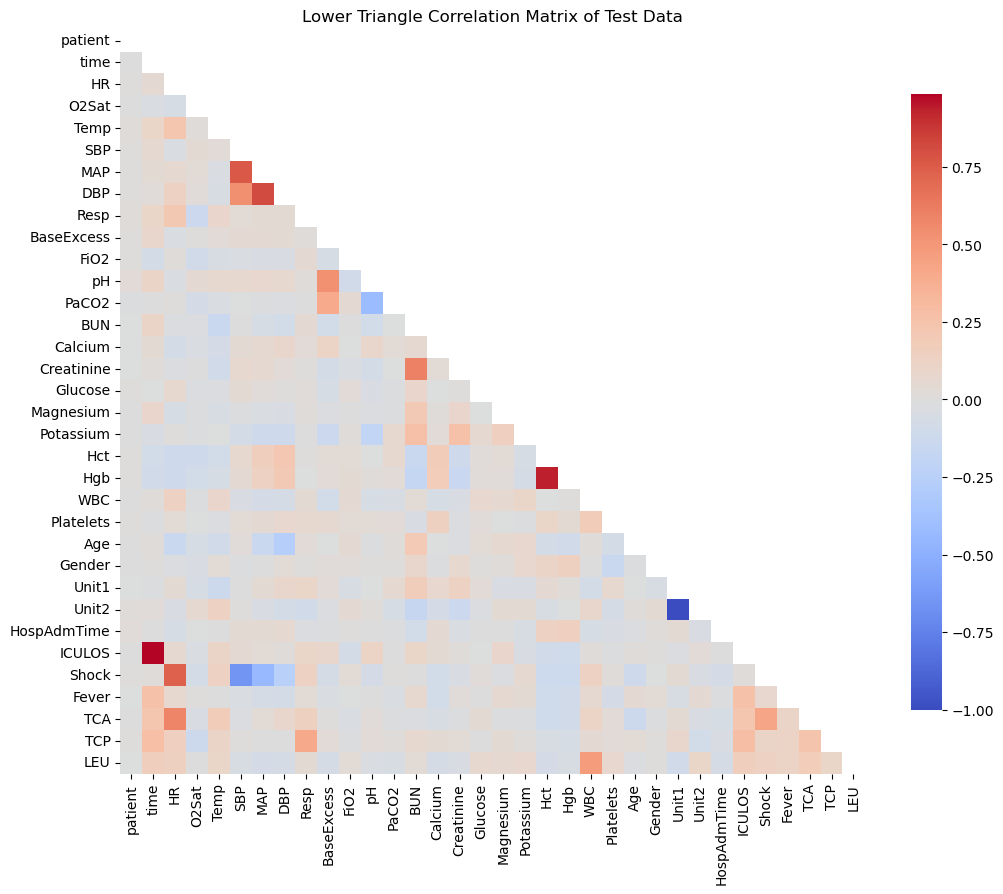

In [141]:
correlation_matrix = imputed_test.corr()

# Mask the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))


# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Create a heatmap of the correlation matrix, masking the upper triangle
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', square=True, mask=mask, cbar_kws={"shrink": .8})

# Set the title
plt.title('Lower Triangle Correlation Matrix of Test Data')
plt.savefig('Plots/corrmat_train_imputed.png')
plt.show()

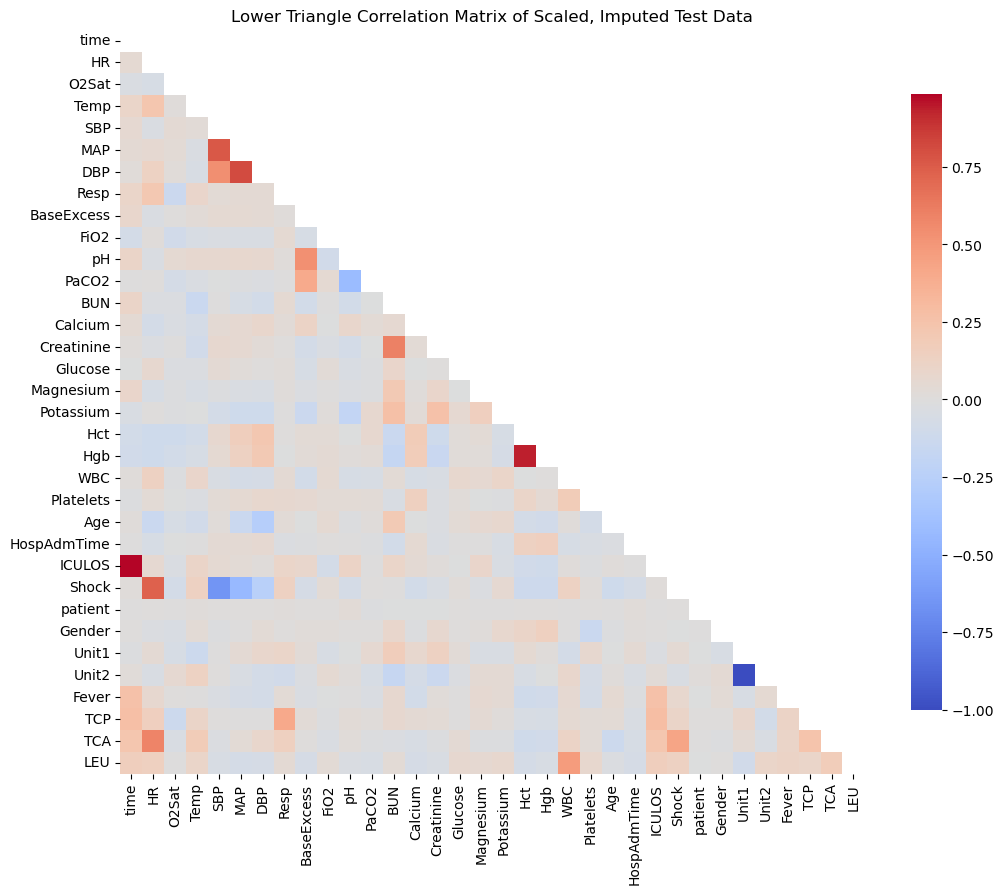

In [142]:
correlation_matrix = scaled_test.corr()

# Mask the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))


# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Create a heatmap of the correlation matrix, masking the upper triangle
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', square=True, mask=mask, cbar_kws={"shrink": .8})

# Set the title
plt.title('Lower Triangle Correlation Matrix of Scaled, Imputed Test Data')
plt.savefig('Plots/corrmat_train_imputed.png')
plt.show()

## Distributions for test data pipeline

In [143]:
#plot_all_variable_distributions(scaled_test)

## Final test data set to csv 

In [144]:
#get rid of the index
scaled_test.to_csv(missForestTestFile)